In [8]:
#| output: false
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(), # 토텐서 변환
        transforms.Normalize((0.4915, 0.4823, 0.4468), # 평균과 표준편차를 가지고 정규화
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

Files already downloaded and verified
Files already downloaded and verified


- 출력 채널은 입력 이미지의 다양한 특징이나 패턴을 감지하는 역할을 합니다.

컨볼루션 레이어의 출력 채널은 입력 이미지에서 다양한 특징이나 패턴을 자동으로 감지하는 역할을 합니다. 이러한 특징은 커널(필터)에 의해 학습되며, 각 출력 채널은 입력 이미지의 서로 다른 부분이나 특징에 대응합니다.

컨볼루션 레이어의 각 출력 채널은 입력 이미지에서 특정한 특징을 감지하는데 특화되어 있습니다. 예를 들어, 첫 번째 출력 채널은 에지(edge)를 감지하거나 특정한 색상에 반응할 수 있고, 두 번째 출력 채널은 다른 모양이나 질감에 반응할 수 있습니다. 이렇게 다양한 특징을 학습하여 모델은 입력 이미지의 복잡한 구조를 이해하고 인식할 수 있습니다.

따라서, 출력 채널의 역할은 모델이 입력 이미지의 다양한 특징을 자동으로 학습하고 추출하는 것이며, 이는 모델이 더 높은 수준의 추상화를 수행할 수 있게 해줍니다.

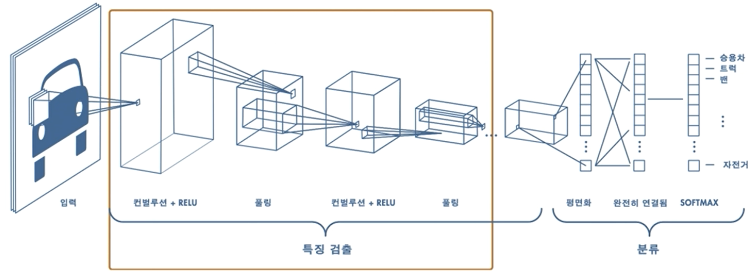

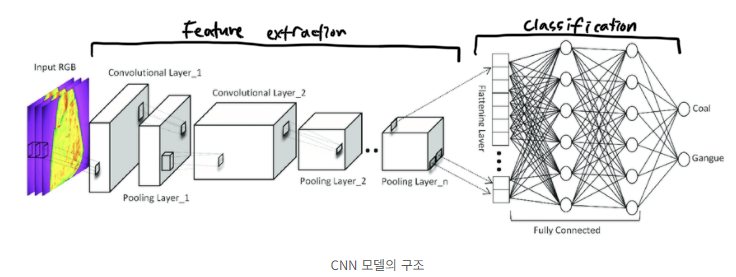

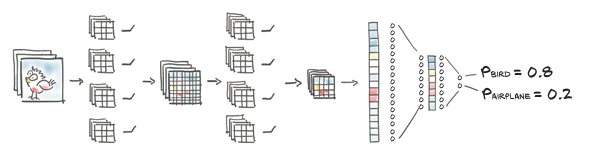

- 아래의 그림은 두번의 컨볼루션을 수행한 그림이다
```bash
nn.Conv2d(3,5,kernel_size=3,padding=1) # 3(RGB)개의 채널을 5개의 채널로
nn.Conv2d(5,6,kernel_size=3,padding=1) # 5개의 채널을 6개의 채널로
```
중간에 활성함수 처리를 하는것을 확인할 수 있고 당연히 일반적인 모델에는 풀링 과정도 포함된다

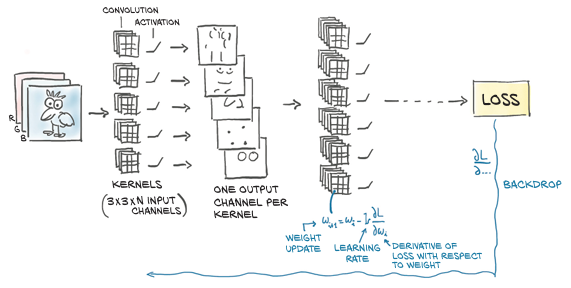

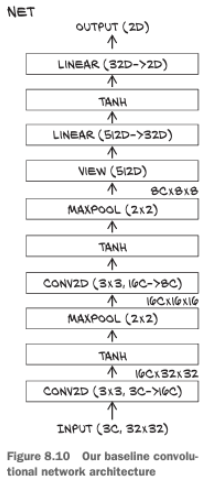

> 3개의 채널(RGB)을 입력을 받고 각각 채널에 3개의 커널에 따라 컨볼루션이 이뤄진 다음 픽셀마다 R+G+B 을 더해서 하나의 이미지, 즉 하나의 채널로 변환되게된다

- conv = nn.Conv2d( 3, 1, kernel_size=3, padding=1 )을 통해 직접 구조를 확인함
- weight 텐서의 차원 정보를 정확하게 본다면 kernel size * in_ch * out_ch = 3 * 3 * 3(RGB) * 16(out_ch)
- 또한 한 채널이 생성될때 RGB 값의 합에 bias도 더하게 된다, bias는 출력 채널당 하나씩 생성된다.
- 즉 출력채널은 원하는 만큼 생성이 가능하고 하나의 출력채널이 만들어질때는 입력채널마다 커널이 만들어지고 가중합이 이뤄진뒤 원하는 출력채널만큼 추가 차원이 생성된다
- 각 채널은 특징점을 포착하는 채널이라고 생각하면 쉽다. ex) 윤곽선, 색상 밝기, 눈코입 같은 특징점 등등
- 한 채널이 어떻게 생성되는지 원리를 깨닫는 것이 중요하다.

In [6]:
# 차원 확인하기
conv = nn.Conv2d(3,16,kernel_size=3,padding=1)
conv.weight.shape,conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [9]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape # 이미지가 3개의 채널(RGB)에서 16개의 채널을 가진 이미지가 됐다

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [11]:
torch.randn(1, 3, 4, 4)

tensor([[[[ 1.9696, -1.5811,  0.0716, -1.4534],
          [ 0.1258,  0.4273, -0.0132,  1.9150],
          [-0.9203,  0.5278, -0.5618,  1.5934],
          [ 0.1542, -0.8334, -0.3344, -2.4584]],

         [[ 0.5048, -0.2681, -0.1297, -0.1383],
          [ 0.5617,  0.9228, -1.1484, -1.0422],
          [ 0.8868, -2.0447,  0.4945,  0.6213],
          [ 0.7073, -0.5441, -2.0697,  0.9890]],

         [[ 0.5626,  0.1718,  1.6276,  2.0309],
          [ 2.2260, -0.4010,  0.8010,  0.0808],
          [ 0.6796, -0.0162, -0.8013,  0.3638],
          [ 0.9727, -0.7129,  1.1638,  0.1203]]]])

In [12]:
torch.randint(1, 6, (1, 3, 4, 4))

tensor([[[[3, 5, 1, 3],
          [5, 3, 4, 2],
          [1, 4, 3, 5],
          [1, 2, 4, 4]],

         [[5, 5, 2, 2],
          [1, 3, 2, 1],
          [2, 4, 5, 5],
          [3, 4, 4, 5]],

         [[5, 3, 1, 3],
          [4, 5, 1, 3],
          [5, 1, 4, 2],
          [3, 3, 4, 5]]]])

In [4]:
conv2 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1)
conv2.bias

Parameter containing:
tensor([ 0.1347, -0.1861,  0.1122,  0.1209, -0.1168, -0.1342],
       requires_grad=True)

In [49]:
int_image = torch.randint(-1, 2, (1, 3, 4, 4), dtype=torch.float32)

conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.bias.zero_()

# 정수 이미지에 합성곱 연산 적용
output_image = conv(int_image)
int_image

tensor([[[[ 0.,  0., -1.,  0.],
          [-1.,  0.,  1.,  0.],
          [ 1.,  0.,  0.,  1.],
          [ 0.,  0.,  1., -1.]],

         [[ 1., -1.,  0.,  1.],
          [-1., -1., -1., -1.],
          [ 1., -1., -1.,  1.],
          [ 1.,  1., -1.,  1.]],

         [[ 0.,  0., -1.,  0.],
          [ 0., -1.,  1.,  1.],
          [ 0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  1.]]]])

In [59]:
int_image

tensor([[[[ 0.,  0., -1.,  0.],
          [-1.,  0.,  1.,  0.],
          [ 1.,  0.,  0.,  1.],
          [ 0.,  0.,  1., -1.]],

         [[ 1., -1.,  0.,  1.],
          [-1., -1., -1., -1.],
          [ 1., -1., -1.,  1.],
          [ 1.,  1., -1.,  1.]],

         [[ 0.,  0., -1.,  0.],
          [ 0., -1.,  1.,  1.],
          [ 0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  1.]]]])

In [57]:
conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
# 정수 이미지에 합성곱 연산 적용
output_image = conv(int_image)

In [61]:
-0.1056+(0.1514-0.0390-0.0042+0.0301)+(-0.0353)

-0.002599999999999991

In [58]:
conv.weight

Parameter containing:
tensor([[[[-0.0065, -0.0099,  0.0652],
          [ 0.1675, -0.0228,  0.1843],
          [-0.1881,  0.1056,  0.1231]],

         [[-0.1634, -0.0401, -0.1059],
          [ 0.0799,  0.1514,  0.0390],
          [-0.1749,  0.0042, -0.0301]],

         [[-0.0027, -0.0447, -0.0565],
          [ 0.1332,  0.1437, -0.1660],
          [ 0.1791, -0.0053,  0.0353]]]], requires_grad=True)

In [60]:
conv.bias

Parameter containing:
tensor([0.1157], requires_grad=True)

In [62]:
output_image

tensor([[[[ 0.1131,  0.5787,  0.1112,  0.1227],
          [ 0.3199, -0.8814,  0.0021,  0.7670],
          [ 0.3917,  0.3587,  0.4272,  0.1836],
          [ 0.3620,  0.4120, -0.1153,  0.6767]]]],
       grad_fn=<ConvolutionBackward0>)

In [63]:
0.1157-0.00259999999999999

0.1131